In [ ]:
# import numpy as np
# from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Session
# from scipy.optimize import minimize
# from qiskit.transpiler import generate_preset_pass_manager
# from qiskit_nature.second_q.drivers import PySCFDriver
# from qiskit_nature.second_q.mappers import JordanWignerMapper
# from qiskit_algorithms import NumPyMinimumEigensolver
# import matplotlib.pyplot as plt

In [ ]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.drivers import PySCFDriver


print("=" * 60)
print("VQE for N2 Molecule on simulator")
print("=" * 60)

# ---- Step 1: Generate N2 Hamiltonian ----
print("\n[1/5] Generating N2 Hamiltonian...")
driver = PySCFDriver(atom='N 0 0 0; N 0 0 1.098', basis='sto3g')
problem = driver.run()
mapper = JordanWignerMapper()
hamiltonian = mapper.map(problem.hamiltonian.second_q_op())

print(f"  ✓ Number of qubits: {hamiltonian.num_qubits}")
print(f"  ✓ Number of Pauli terms: {len(hamiltonian)}")

VQE for N2 Molecule on IBM Quantum Computer

[1/5] Generating N2 Hamiltonian...
  ✓ Number of qubits: 20
  ✓ Number of Pauli terms: 2951


In [3]:
# Nuclear repulsion energy for N2 at 1.098 Å
Z_N = 7  # Atomic number from periodic table
R = 1.098  # Å
R_bohr = R * 1.88973  # Conversion: 1 Å = 1.88973 Bohr
E_nuc = (Z_N * Z_N) / R_bohr  # Nuclear repulsion energy in Ha

print(f"  ✓ Nuclear repulsion energy: {E_nuc:.6f} Ha")

  ✓ Nuclear repulsion energy: 23.615328 Ha


In [4]:
# Create Hartree-Fock initial state
from qiskit_nature.second_q.circuit.library import HartreeFock

hf_state = HartreeFock(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=problem.num_particles,
    qubit_mapper=mapper
)


This circuit has  40 parameters


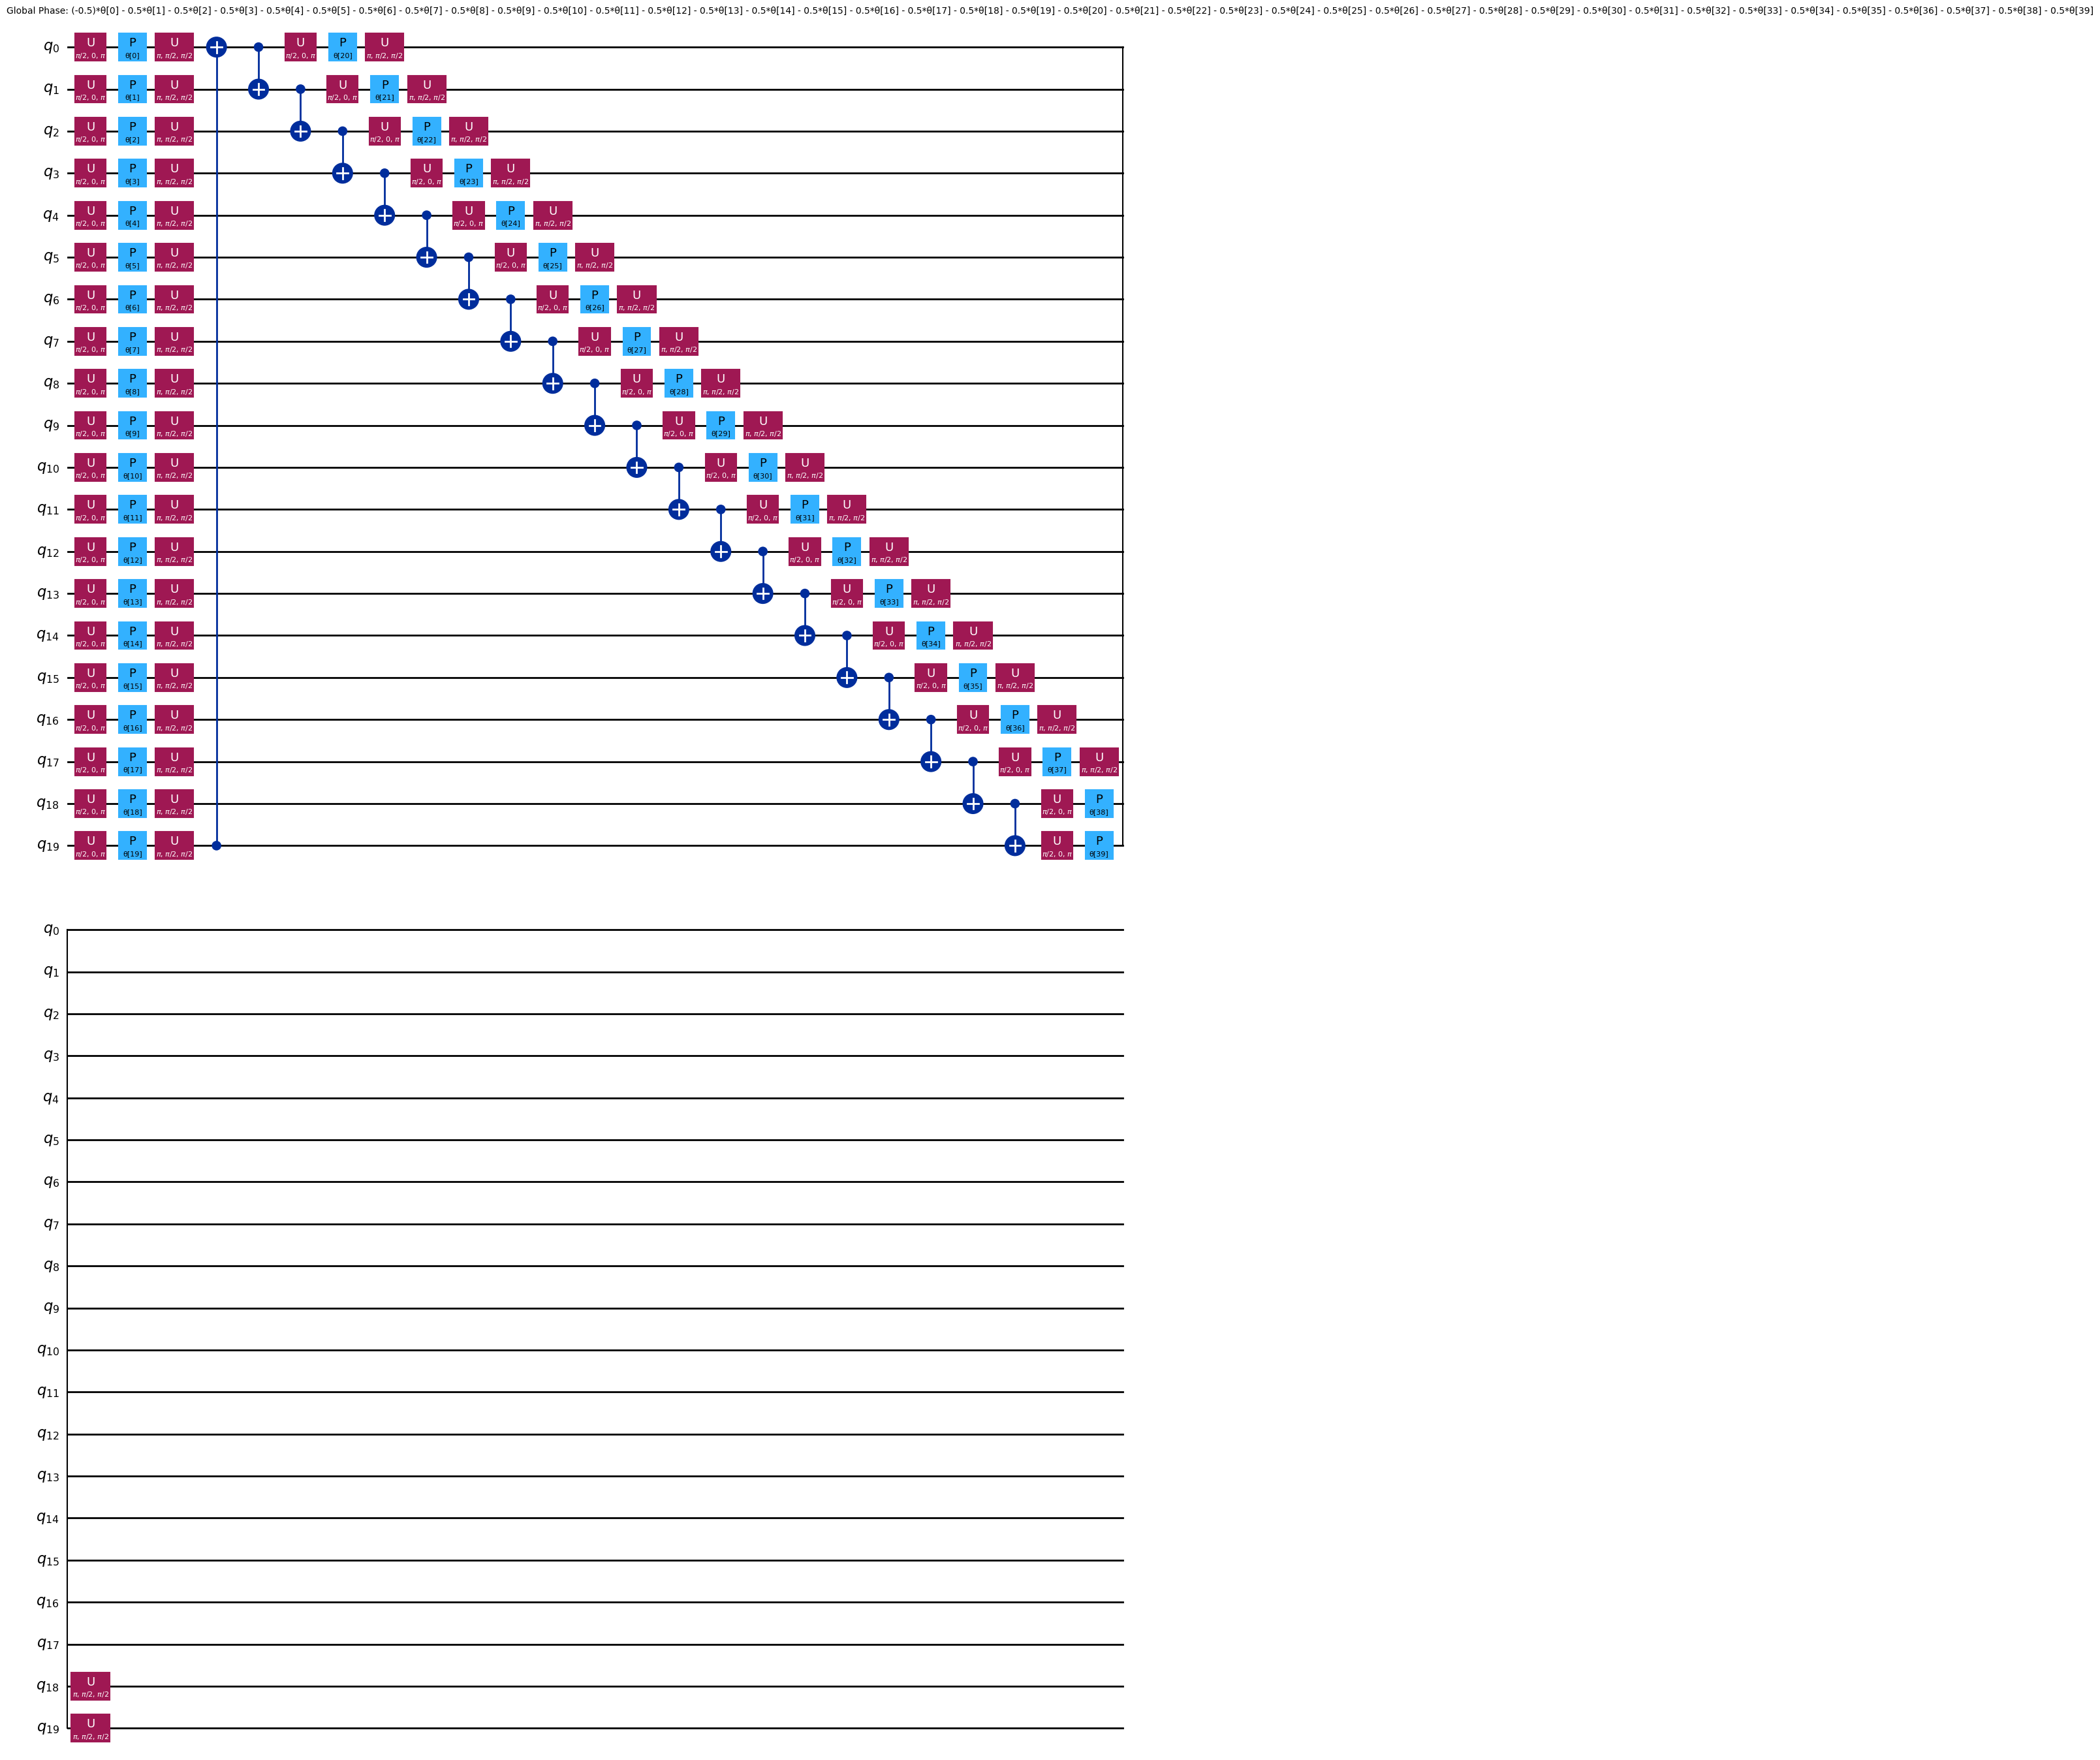

In [5]:
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import efficient_su2
 
# Note that it is more common to place initial 'h' gates outside the ansatz. Here we specifically wanted this layer structure.
ansatz = efficient_su2(
    hamiltonian.num_qubits, su2_gates=["h", "rz", "y"], entanglement="circular", reps=1
)
num_params = ansatz.num_parameters
print("This circuit has ", num_params, "parameters")
 
ansatz.decompose().draw("mpl", style="iqp")

In [7]:
from scipy.optimize import minimize
from qiskit_aer.primitives import EstimatorV2 as Estimator
import numpy as np

iterations = [0]
def cost_function(params):
    estimator = Estimator()
    iterations[0] += 1
    print(f"Iteration {iterations[0]}: Evaluating cost function...")
    hf_circuit = hf_state.compose(ansatz)
    bound_circuit = hf_circuit.assign_parameters(params)
    job = estimator.run([(bound_circuit, hamiltonian)])
    result = job.result()
    electronic = result[0].data.evs
    print(f"  Energy: {electronic + problem.nuclear_repulsion_energy:.6f} Ha")


    return electronic + problem.nuclear_repulsion_energy

# Optimize!
initial_params = np.zeros(ansatz.num_parameters)
print("Optimizing parameters...")
result = minimize(
    fun=cost_function, 
    x0=initial_params, 
    method='COBYLA', 
    options={'maxiter': 250}
    )

print(f"\nOptimized energy: {result.fun:.6f} Ha")
print(f"Expected:         -108.9505 Ha")
print(f"Error:            {abs(result.fun + 108.9505):.6f} Ha")

Optimizing parameters...
Iteration 1: Evaluating cost function...
  Energy: -105.501573 Ha
Iteration 2: Evaluating cost function...
  Energy: -102.114154 Ha
Iteration 3: Evaluating cost function...
  Energy: -98.959348 Ha
Iteration 4: Evaluating cost function...
  Energy: -102.070759 Ha
Iteration 5: Evaluating cost function...
  Energy: -105.439831 Ha
Iteration 6: Evaluating cost function...
  Energy: -105.588370 Ha
Iteration 7: Evaluating cost function...
  Energy: -105.663654 Ha
Iteration 8: Evaluating cost function...
  Energy: -105.632063 Ha
Iteration 9: Evaluating cost function...
  Energy: -105.780191 Ha
Iteration 10: Evaluating cost function...
  Energy: -105.847191 Ha
Iteration 11: Evaluating cost function...
  Energy: -105.606860 Ha
Iteration 12: Evaluating cost function...
  Energy: -102.248862 Ha
Iteration 13: Evaluating cost function...
  Energy: -98.926727 Ha
Iteration 14: Evaluating cost function...
  Energy: -102.065929 Ha
Iteration 15: Evaluating cost function...
  Ener